<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment01/PCD_Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#
##Nama  : Sapto Nugroho
##NIU   : 565712

###git clone

In [668]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

PCD  sample_data
fatal: destination path 'PCD' already exists and is not an empty directory.
PCD  sample_data


##function================================================================================================================

###Import

In [669]:
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics as st
import pdb
from scipy.interpolate import CubicSpline

###Image Acquisition

In [670]:
def Acquire(src,size):
  #Image and Copy
  img = plt.imread(src)
  img_copy = img.copy()

  #Plot Image dan Copy
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img)
  axs[0].set_title(f"Original, shape, {img.shape}")
  axs[1].imshow(img_copy)
  axs[1].set_title(f"Copy, shape {img_copy.shape}")
  plt.tight_layout()
  plt.show()

  return img, img_copy

###Downsampling

In [671]:
def DownSample(img_copy,order,size):
  div = 2**order

  #baris
  baris = img_copy.shape[0]//div
  print(f"baris = {baris}, sisa baris = {img_copy.shape[0]%div}")

  #kolom
  kolom = img_copy.shape[1]//div
  print(f"kolom = {kolom}, sisa kolom = {img_copy.shape[1]%div}")

  #Matriks Image DownSample (img_ds)
  img_ds = np.zeros(shape=(baris,kolom,3),dtype=np.uint8)
  print(img_copy.shape,"==>",img_ds.shape)
  #print(img_ds)

  #DownSampling
  for j in range(0,img_ds.shape[0]):
    # print("J= ",j,j*div)
    for i in range(0,img_ds.shape[1]):
      # print(i, i*div)
      img_ds[j][i] = img_copy[j*div][i*div]

  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_ds)
  axs[1].set_title(f"After, shape {img_ds.shape}")
  # fig.suptitle("Downsampling", fontsize=16)
  plt.tight_layout()
  plt.show()

  return img_ds


###Decimation

In [672]:
#new Decimate
def Decimate(mode,img_copy,baris_baru,kolom_baru,size):

  img_copy = img_copy.astype(int)
  baris_lama, kolom_lama, c = img_copy.shape

  #Matriks Image Decimation (img_dc)
  img_dc = np.zeros(shape=(baris_baru,kolom_baru,3),dtype=int)

  k_baris = (baris_lama - 1)/(baris_baru) if baris_baru != 0 else 0
  k_kolom = (kolom_lama - 1)/(kolom_baru) if kolom_baru != 0 else 0

  match mode:
    case 'MAX':
      mode = "Max"
      for i in range(baris_baru):
        for j in range(kolom_baru):

          x1 = math.ceil(i*k_baris)
          x2 = math.floor((i+1)*k_baris)
          y1 = math.ceil(j*k_kolom)
          y2 = math.floor((j+1)*k_kolom)
          dx = x2-x1+1
          dy = y2-y1+1

          q = np.array([0,0,0])
          if (x2 == x1) and (y2 == y1):
            img_dc[i,j,:] = img_copy[x1, y1,:]

          elif (x2 == x1):
            for k in range(y1,y2+1):
              img_dc[i,j,0] = max(img_dc[i,j,0],img_copy[x1,k,0])
              img_dc[i,j,1] = max(img_dc[i,j,1],img_copy[x1,k,1])
              img_dc[i,j,2] = max(img_dc[i,j,2],img_copy[x1,k,2])

          elif (y2 == y1):
            for k in range(x1,x2+1):
              img_dc[i,j,0] = max(img_dc[i,j,0],img_copy[k,y1,0])
              img_dc[i,j,1] = max(img_dc[i,j,1],img_copy[k,y1,1])
              img_dc[i,j,2] = max(img_dc[i,j,2],img_copy[k,y1,2])

          else:
            for k in range(x1,x2+1):
              for l in range(y1,y2+1):
                img_dc[i,j,0] = max(img_dc[i,j,0],img_copy[k, l,0])
                img_dc[i,j,1] = max(img_dc[i,j,1],img_copy[k, l,1])
                img_dc[i,j,2] = max(img_dc[i,j,2],img_copy[k, l,2])

    case 'MEDIAN':
      mode = "Median"
      temp = [[],[],[]]
      for i in range(baris_baru):
        for j in range(kolom_baru):

          x1 = math.ceil(i*k_baris)
          x2 = math.floor((i+1)*k_baris)
          y1 = math.ceil(j*k_kolom)
          y2 = math.floor((j+1)*k_kolom)
          dx = x2-x1+1
          dy = y2-y1+1

          q = np.array([0,0,0])
          if (x2 == x1) and (y2 == y1):
            img_dc[i,j,0] = img_copy[x1, y1,0]
            img_dc[i,j,1] = img_copy[x1, y1,1]
            img_dc[i,j,2] = img_copy[x1, y1,2]

          elif (x2 == x1):
            for k in range(y1,y2+1):
              temp[0].append(img_copy[x1,k,0])
              temp[1].append(img_copy[x1,k,1])
              temp[2].append(img_copy[x1,k,2])

          elif (y2 == y1):
            for k in range(x1,x2+1):
              temp[0].append(img_copy[k,y1,0])
              temp[1].append(img_copy[k,y1,1])
              temp[2].append(img_copy[k,y1,2])

          else:
            for k in range(x1,x2+1):
              for l in range(y1,y2+1):
                temp[0].append(img_copy[k,l,0])
                temp[1].append(img_copy[k,l,1])
                temp[2].append(img_copy[k,l,2])

          img_dc[i,j,0] = st.median(temp[0])
          img_dc[i,j,1] = st.median(temp[1])
          img_dc[i,j,2] = st.median(temp[2])
          temp = [[],[],[]]

    case 'MEAN':
      mode = "Mean"
      for i in range(baris_baru):
        for j in range(kolom_baru):

          x1 = math.ceil(i*k_baris)
          x2 = math.floor((i+1)*k_baris)
          y1 = math.ceil(j*k_kolom)
          y2 = math.floor((j+1)*k_kolom)
          dx = x2-x1+1
          dy = y2-y1+1
          # pdb.set_trace()

          q = np.array([0,0,0])
          if (x2 == x1) and (y2 == y1):
            img_dc[i,j,0] = img_copy[x1, y1,0]
            img_dc[i,j,1] = img_copy[x1, y1,1]
            img_dc[i,j,2] = img_copy[x1, y1,2]

          elif (x2 == x1):
            for k in range(y1,y2+1):
              img_dc[i,j,:] += img_copy[x1, k,:]
            img_dc[i,j,:] = np.round(img_dc[i,j,:]/(dx*dy))

          elif (y2 == y1):
            for k in range(x1,x2+1):
              img_dc[i,j,:] += img_copy[k, y1,:]
            img_dc[i,j,:] = np.round(img_dc[i,j,:]/(dx*dy))

          else:
            for k in range(x1,x2+1):
              for l in range(y1,y2+1):
                img_dc[i,j,:] += img_copy[k, l,:]
            img_dc[i,j,:] = np.round(img_dc[i,j,:]/(dx*dy))
            # pdb.set_trace()

          # img_dc[i,j,:] = q1

  img_dc = img_dc.astype(np.uint8)

  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_dc)
  axs[1].set_title(f"After, shape {img_dc.shape}")

  # fig.suptitle(f"Upsample({mode})", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=1.45)
  plt.show()

  return img_dc


###Upsampling

####Nearest Neighbor

In [673]:
def up_NN(img_copy,baris_baru,kolom_baru,size):
  img_copy = img_copy.astype(int)

  baris_lama, kolom_lama, c = img_copy.shape
  # print(baris_lama,kolom_lama,c)

  # baris_baru = baris_lama*order
  # kolom_baru = kolom_lama*order

  img_us = np.zeros(shape=(baris_baru,kolom_baru,c))

  k_baris = (baris_lama)/(baris_baru) if baris_baru != 0 else 0
  k_kolom = (kolom_lama)/(kolom_baru) if kolom_baru != 0 else 0

  for i in range(baris_baru):
    for j in range(kolom_baru):

      #pemetaan koordinat baru ke lama (koordinat lama = koordinat baru * skala)
      x = i*k_baris
      y = j*k_kolom

      #4-Neighborhood dari (x,y)
      x1 = math.floor(x)
      x2 = min(baris_lama - 1, math.ceil(x))
      y1 = math.floor(y)
      y2 = min(kolom_lama - 1, math.ceil(y))

      if (x2 == x1) and (y2 == y1):
        q = img_copy[int(x), int(y), :]
      elif (x2 == x1):
        for k in range(c):
          q[k] = min(img_copy[int(x), int(y1), k],img_copy[int(x), int(y2), k])
      elif (y2 == y1):

        for k in range(c):
          q[k] = min(img_copy[int(x1), int(y), k],img_copy[int(x2), int(y), k])
      else:
        v1 = img_copy[x1, y1, :]
        v2 = img_copy[x2, y1, :]
        v3 = img_copy[x1, y2, :]
        v4 = img_copy[x2, y2, :]
        for k in range(c):
          q[k] = min(v1[k],v2[k],v3[k],v4[k])

      img_us[i,j,:] = q

  img_us = img_us.astype(np.uint8)
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_us)
  axs[1].set_title(f"After, shape {img_us.shape}")

  # fig.suptitle(f"Upsample({mode})", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=1.45)
  plt.show()

  return img_us

####Bilinear

In [674]:
def up_Bilinear(img_copy,baris_baru,kolom_baru,size):

  img_copy = img_copy.astype(int)

  baris_lama, kolom_lama, c = img_copy.shape
  # print(baris_lama,kolom_lama,c)

  img_us = np.zeros(shape=(baris_baru,kolom_baru,c))

  k_baris = (baris_lama)/(baris_baru) if baris_baru != 0 else 0
  k_kolom = (kolom_lama)/(kolom_baru) if kolom_baru != 0 else 0

  for i in range(baris_baru):
    for j in range(kolom_baru):

      #pemetaan koordinat baru ke lama (koordinat lama = koordinat baru * skala)
      x = i*k_baris
      y = j*k_kolom

      #4-Neighborhood dari (x,y)
      x1 = math.floor(x)
      x2 = min(baris_lama - 1, math.ceil(x))
      y1 = math.floor(y)
      y2 = min(kolom_lama - 1, math.ceil(y))

      if (x2 == x1) and (y2 == y1):
        q = img_copy[int(x), int(y), :]
      elif (x2 == x1):
        q1 = img_copy[int(x), int(y1), :]
        q2 = img_copy[int(x), int(y2), :]
        q = q1 * (y2 - y) + q2 * (y - y1)
      elif (y2 == y1):
        q1 = img_copy[int(x1), int(y), :]
        q2 = img_copy[int(x2), int(y), :]
        q = (q1 * (x2 - x)) + (q2	 * (x - x1))
      else:
        v1 = img_copy[x1, y1, :]
        v2 = img_copy[x2, y1, :]
        v3 = img_copy[x1, y2, :]
        v4 = img_copy[x2, y2, :]

        q1 = v1 * (x2 - x) + v2 * (x - x1)
        q2 = v3 * (x2 - x) + v4 * (x - x1)
        q = q1 * (y2 - y) + q2 * (y - y1)

      img_us[i,j,:] = q

  img_us = img_us.astype(np.uint8)
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_us)
  axs[1].set_title(f"After, shape {img_us.shape}")

  # fig.suptitle(f"Upsample({mode})", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=1.45)
  plt.show()

  return img_us

####Bicubic

In [723]:
def up_Bicubic(img_copy,baris_baru,kolom_baru,size):
  img_copy = img_copy.astype(int)
  baris_lama, kolom_lama, c = img_copy.shape

  img_us = np.zeros(shape=(baris_baru,kolom_baru,c), dtype=int)

  k_baris = (baris_baru)/(baris_lama) if baris_baru != 0 else 0
  k_kolom = (kolom_baru)/(kolom_lama) if kolom_baru != 0 else 0
  k = 10

  #rgb[channel][baris_lama][kolom_lama]
  r,g,b= img[:,:,0],img[:,:,1],img[:,:,2]
  rgb = [r,g,b]

  temp_xs = []
  temp_ys = []

  #Divide And Conquer (kolom kemudian baris)
  for h in range(c):#iterasi channel (RGB)
    for i in range(len(rgb[h][:])):#iterasi kolom RGB

      #xs       = x-axis bc interpolate
      #ys_RGB[channel][baris]  = y-axis bc interpolate
      #len(xs) = len(ys_RGB[channel][baris]) = len(kolom_lama)
      xs = np.arange(0,len(rgb[h][i]))
      # print(len(rgb[h][i]))
      # print(xs.shape)
      #kolom wise
      cs = CubicSpline(xs, rgb[h][i],bc_type='natural')

      # sample = n*k*k'
      sample = math.ceil(len(rgb[h][i])*k*(k_kolom))

      # new_xs = np.linspace(0,len(r)-1,(len(r)-1)*10)
      new_xs = np.linspace(0,len(rgb[h][i]),sample)
      new_ys = cs(new_xs)
      new_ys = new_ys.astype(int)

      ys2 = new_ys.copy()

      for i in range(len(ys2)):
        if ys2[i] > 255:
          new_ys[i] = new_ys[i-1]
        elif ys2[i] < 0:
          new_ys[i] = new_ys[i-1]

      temp_ys.append(new_ys)
      temp_xs.append(new_xs)

  #temp_ys[channel,baris,kolom(sample)]
  temp_ys = np.array(temp_ys)
  temp_ys = temp_ys.reshape(c,len(rgb[0][:]),sample)

  #temp_xs[channel,baris,kolom(sample)]
  temp_xs = np.array(temp_xs)
  temp_xs = temp_xs.reshape(c,len(rgb[0][:]),sample)

  # print(temp_ys.shape)


  #==============================================================================

  temp_xs1 = []
  temp_ys1 = []

  z = np.zeros(shape=(c,baris_lama,kolom_baru),dtype=int)

  for i in range(c):
    for j in range(kolom_baru):
      z[i,:,j] = temp_ys[i,:,j*k]

  # print(z.shape)
  z = z.astype(np.uint8)
  z = np.swapaxes(z,1,2)
  # print(z.shape)
  # print(len(z[i,j,:]))
  # print(z[i,j,:])
  #Divide And Conquer (kolom kemudian baris)
  for i in range(c):
    for j in range(len(z[i,:])):

      xs1 = np.arange(0,len(z[h,j,:]))
      # print(xs1.shape)
      cs2 = CubicSpline(xs1,z[i,j,:],bc_type='natural')

      sample = math.ceil(len(z[i,j])*k*((k_baris)))

      new_xs1 = np.arange(0,len(z[i,j]),sample)
      new_xs1 = np.linspace(0,len(z[i,j]),sample)
      new_ys1 = cs2(new_xs1)
      new_ys1 = new_ys1.astype(int)

      ys3 = new_ys1.copy()

      for m in range(len(ys3)):
        if ys3[m] > 255:
          new_ys1[m] = new_ys1[m-1]
        elif ys3[m] < 0:
          new_ys1[m] = new_ys1[m-1]

      temp_ys1.append(new_ys1)
      temp_xs1.append(new_xs1)

  # #temp_ys1[channel,baris,kolom(sample)]
  temp_ys1 = np.array(temp_ys1)
  temp_ys1 = temp_ys1.reshape(c,len(z[0,:]),sample)

  # #temp_xs1[channel,baris,kolom(sample)]
  temp_xs1 = np.array(temp_xs1)
  temp_xs1 = temp_xs1.reshape(c,len(z[0,:]),sample)

  z = np.zeros(shape=(c,kolom_baru,baris_baru),dtype=int)

  for i in range(c):
    for j in range(baris_baru):
      z[i,:,j] = temp_ys1[i,:,j*k]

  z = z.astype(np.uint8)
  z = np.swapaxes(z,0,1)
  z = np.swapaxes(z,1,2)
  z = np.swapaxes(z,0,1)
  img_us = z

  # #==============================================================================
  # # PLOT
  img_us = img_us.astype(np.uint8)
  fig, axs = plt.subplots(1, 2, figsize=(10, 10))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_us)
  axs[1].set_title(f"After, shape {img_us.shape}")
  # fig.suptitle(f"Upsample({mode})", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=1.45)
  plt.show()

  return img_us

##main()==================================================================================================================

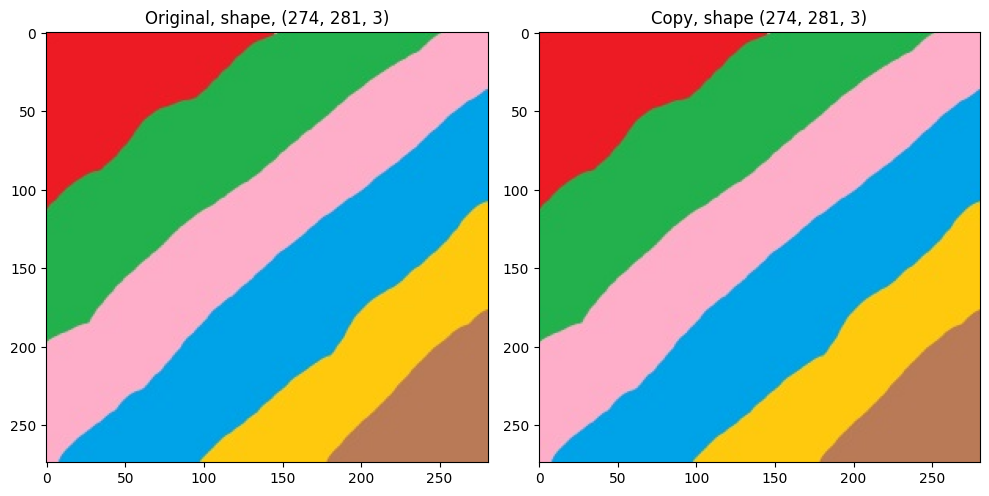

In [676]:
# img_path = '/content/PCD/PCD_Assignment01/grid.jpg'
# img_path = '/content/PCD/PCD_Assignment01/grid01.jpg'
# img_path = '/content/PCD/PCD_Assignment01/grid02.jpg'
# img_path = '/content/PCD/PCD_Assignment01/4x4.jpg'
# img_path = '/content/PCD/PCD_Assignment01/4x4color.jpg'
# img_path = '/content/PCD/PCD_Assignment01/8x8color.jpg'
# img_path = '/content/PCD/PCD_Assignment01/8x8white.jpg'
# img_path = '/content/PCD/PCD_Assignment01/16x16.jpg'
# img_path = '/content/PCD/PCD_Assignment01/64x64.jpg'
# img_path = '/content/PCD/PCD_Assignment01/128x128.jpg'
img_path = '/content/PCD/PCD_Assignment01/color01.jpg'
# img_path = '/content/PCD/PCD_Assignment01/color02.jpg'
# img_path = '/content/PCD/PCD_Assignment01/clouds.jpg'
# img_path = '/content/PCD/PCD_Assignment01/mountain.jpg'
# img_path = '/content/thunder16x16.jpg'

img,img_copy = Acquire(img_path,10)
# print(img[0][0],img_copy[-1][-1])

baris = 146, sisa baris = 0
kolom = 180, sisa kolom = 0
(292, 360, 3) ==> (146, 180, 3)


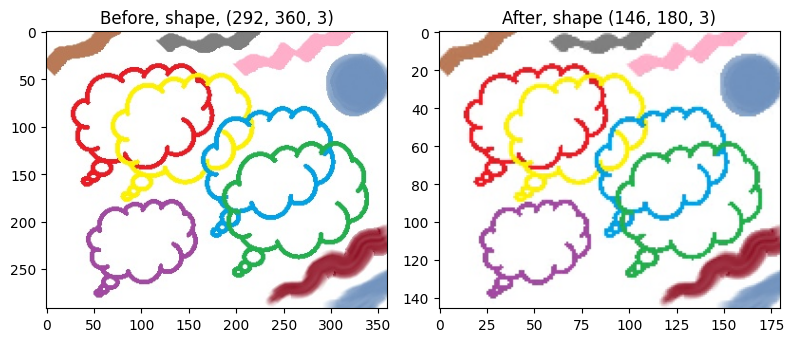

In [ ]:
#DownSample(img_copy,order,size)
img_ds = DownSample(img_copy,1,8)

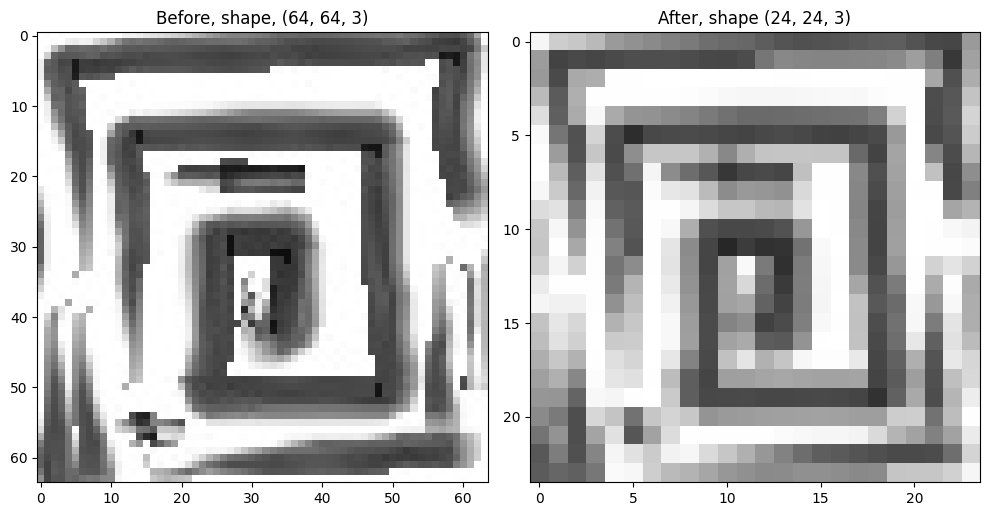

In [ ]:
#Decimate(mode,img_copy,baris_baru,kolom_baru,size)
img_dc = Decimate('MEAN',img_copy,24,24,10)


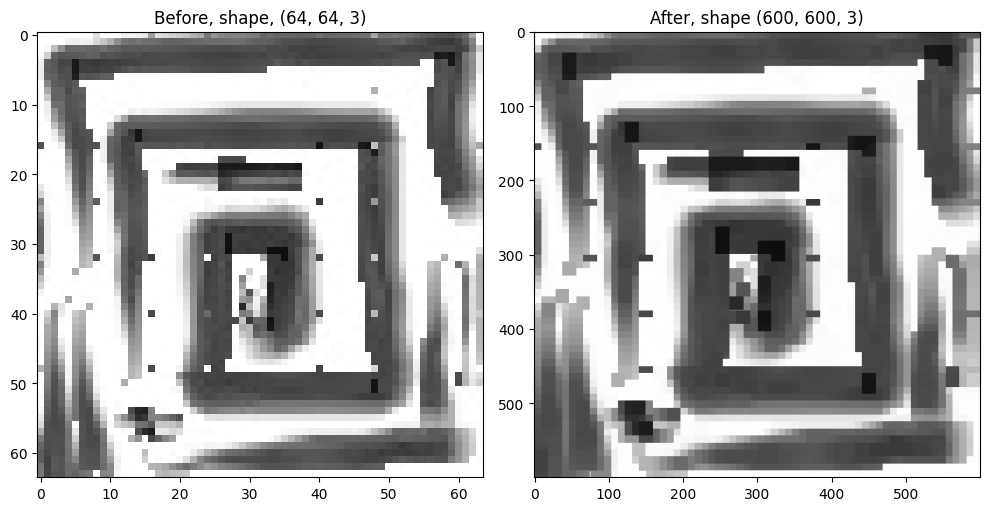

In [ ]:
#####up_NN(img_copy,baris_baru,kolom_baru,size)
img_us = up_NN(img_copy,600,600,10)

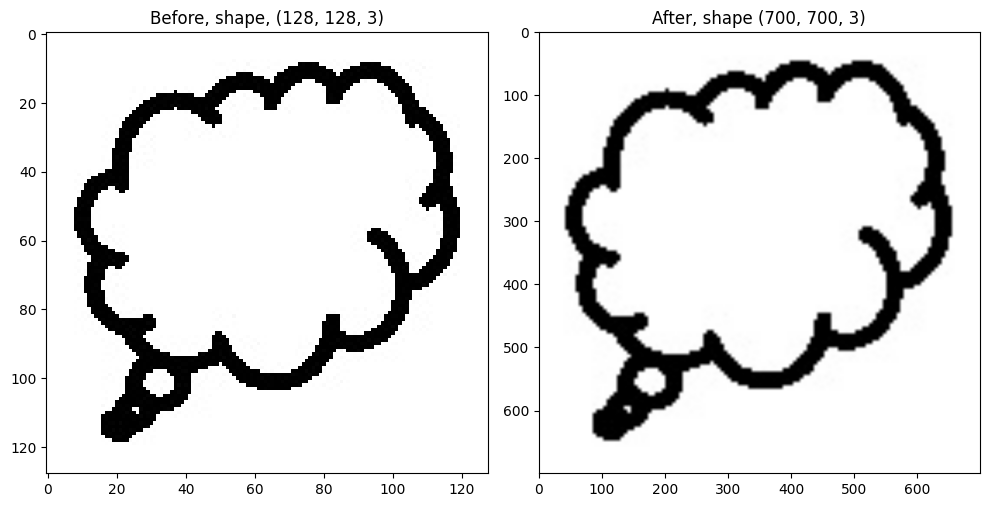

In [ ]:
#####up_Bilinear(img_copy,baris_baru,kolom_baru,size)
img_us = up_Bilinear(img_copy,700,700,10)

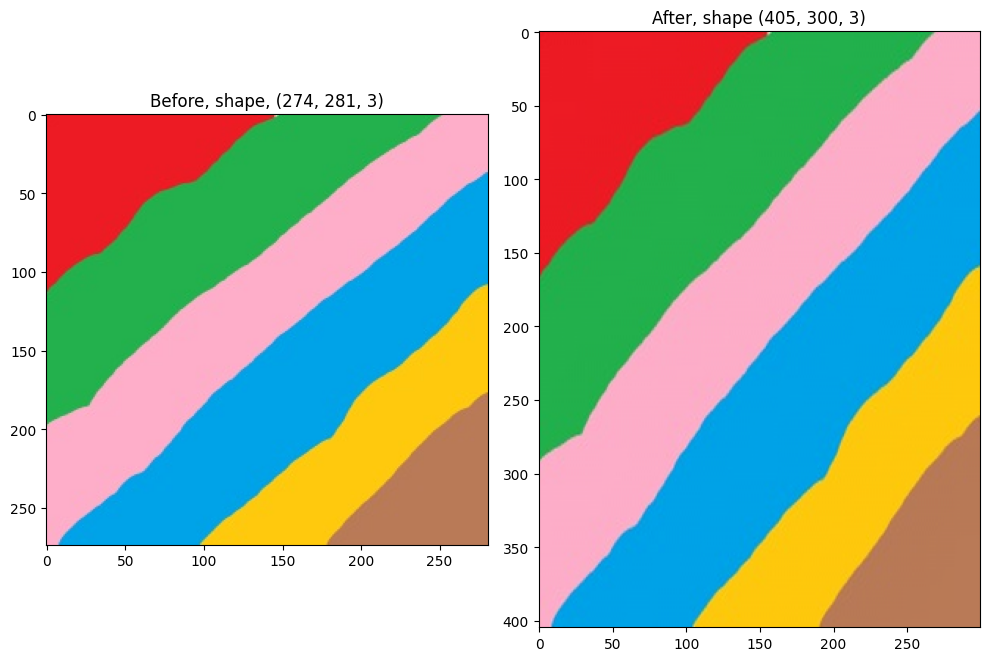

In [726]:
#up_Bicubic(img_copy,baris_baru,kolom_baru,size)
img_us = up_Bicubic(img_copy,405,300,10)